{'node_1': {'foo': 'hi! foo'}}
{'node_2': {'foo': 'hi! foobar'}}


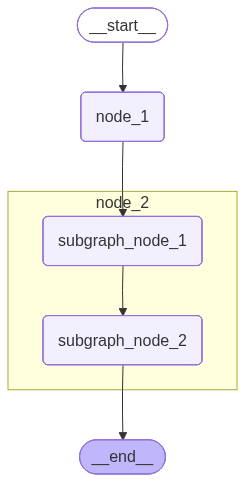

In [3]:
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START

# Define subgraph
class SubgraphState(TypedDict):
    foo: str  # shared with parent graph state
    bar: str  # private to SubgraphState

def subgraph_node_1(state: SubgraphState):
    return {"bar": "bar"}

def subgraph_node_2(state: SubgraphState):
    # note that this node is using a state key ('bar') that is only available in the subgraph
    # and is sending update on the shared state key ('foo')
    return {"foo": state["foo"] + state["bar"]}

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()

# Define parent graph
class ParentState(TypedDict):
    foo: str

def node_1(state: ParentState):
    return {"foo": "hi! " + state["foo"]}

builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", subgraph)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
graph = builder.compile()

for chunk in graph.stream({"foo": "foo"}):
    print(chunk)

from IPython.display import Image
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))